<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_Normal_RE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [ ]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [ ]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[2] #Normal with RE
test_file = file_path+file[3]
dataset= "Normal with Response Encoding"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 373), (11403, 373), (75818, 373))

In [ ]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [ ]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [ ]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [ ]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   58.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  3.6min finished


The best auc score was 0.811
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 8.97 s, sys: 1.3 s, total: 10.3 s
Wall time: 3min 37s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                  solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Normal with Response Encoding dataset 		 



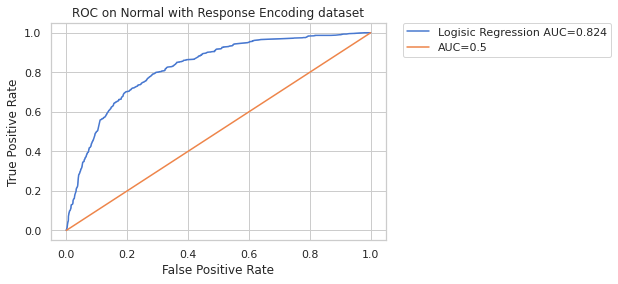

The log loss and auc was found to be 0.524 and 0.824 for Logisic Regression on Normal with Response Encoding dataset.


In [ ]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059


# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished


The best auc score was 0.758
The best params were: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': 5000, 'max_depth': 10}
CPU times: user 5.36 s, sys: 247 ms, total: 5.6 s
Wall time: 5min 21s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                      splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=5000,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
           

		 Decision Tree Classifier on Normal with Response Encoding dataset 		 



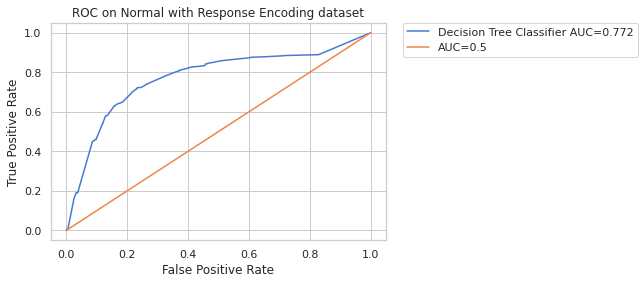

The log loss and auc was found to be 0.149 and 0.772 for Decision Tree Classifier on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[500,1000,2000],
          'max_depth':[500,1000,2000], 
         'min_samples_split':[100,500,1000],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250,500] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 41.1min finished


The best auc score was 0.823
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 500, 'max_depth': 1000}
CPU times: user 6min 33s, sys: 1.06 s, total: 6min 34s
Wall time: 47min 42s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=500, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=500, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 10min 14s, sys: 2.02 s, total: 10min 16s
Wall time: 5min 13s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=500, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=500,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier on Normal with Response Encoding dataset 		 



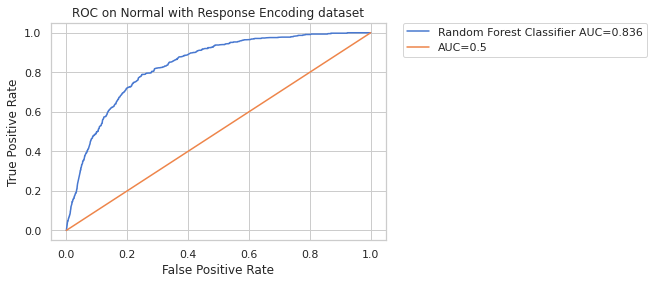

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302


# Selecting top features

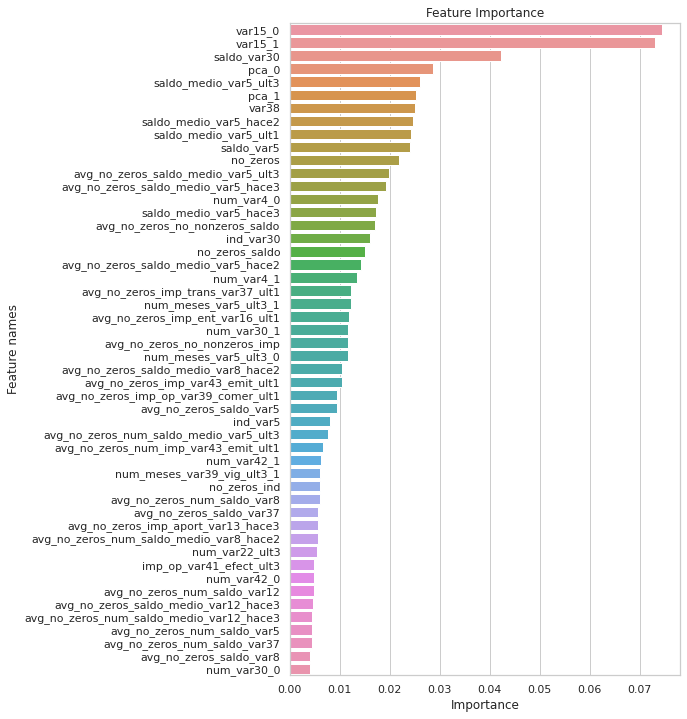

In [ ]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [ ]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_test[features].copy()

There are 28 features that have feature importance value above 0.01000


In [ ]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_test[features].copy()

Taking top 100 features


In [ ]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_test[features].copy()

Taking top 250 features


# XGB Classifier

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=100,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=5,random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.786918	validation_0-error:0.040077
[1]	validation_0-auc:0.788517	validation_0-error:0.039551
[2]	validation_0-auc:0.797337	validation_0-error:0.039551
[3]	validation_0-auc:0.807202	validation_0-error:0.039551
[4]	validation_0-auc:0.812799	validation_0-error:0.039551
[5]	validation_0-auc:0.814734	validation_0-error:0.039551
[6]	validation_0-auc:0.818765	validation_0-error:0.039551
[7]	validation_0-auc:0.821537	validation_0-error:0.039551
[8]	validation_0-auc:0.822713	validation_0-error:0.039551
[9]	validation_0-auc:0.824715	validation_0-error:0.039551
[10]	validation_0-auc:0.826949	validation_0-error:0.039551
[11]	validation_0-auc:0.828183	validation_0-error:0.039551
[12]	validation_0-auc:0.828064	validation_0-error:0.039551
[13]	validation_0-auc:0.82791	validation_0-error:0.039551
[14]	validation_0-auc:0.829498	validation_0-error:0.039551
[15]	validation_0-auc:0.831052	validation_0-error:0.039551
[16]	validation_0-auc:0.831889	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer on Normal with Response Encoding dataset 		 



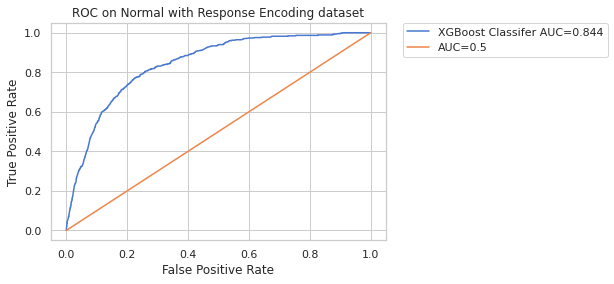

The log loss and auc was found to be 0.134 and 0.844 for XGBoost Classifer on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006


# LightGBM Classifier

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=5,random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.796108	valid_0's binary_logloss: 0.165883
[2]	valid_0's auc: 0.824362	valid_0's binary_logloss: 0.165166
[3]	valid_0's auc: 0.830388	valid_0's binary_logloss: 0.164422
[4]	valid_0's auc: 0.829139	valid_0's binary_logloss: 0.163899
[5]	valid_0's auc: 0.832483	valid_0's binary_logloss: 0.163261
[6]	valid_0's auc: 0.834409	valid_0's binary_logloss: 0.16265
[7]	valid_0's auc: 0.836669	valid_0's binary_logloss: 0.16201
[8]	valid_0's auc: 0.836337	valid_0's binary_logloss: 0.161514
[9]	valid_0's auc: 0.837537	valid_0's binary_logloss: 0.16091
[10]	valid_0's auc: 0.837766	valid_0's binary_logloss: 0.160366
[11]	valid_0's auc: 0.838603	valid_0's binary_logloss: 0.159845
[12]	valid_0's auc: 0.838509	valid_0's binary_logloss: 0.159351
[13]	valid_0's auc: 0.83915	valid_0's binary_logloss: 0.158823
[14]	valid_0's auc: 0.839994	valid_0's binary_logloss: 0.158311
[15]	valid_0's auc: 0.83937	valid_0's binary_logloss: 0.157915
[16]	valid_0's auc: 0.838978	valid_0's binary_logloss:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Normal with Response Encoding dataset 		 



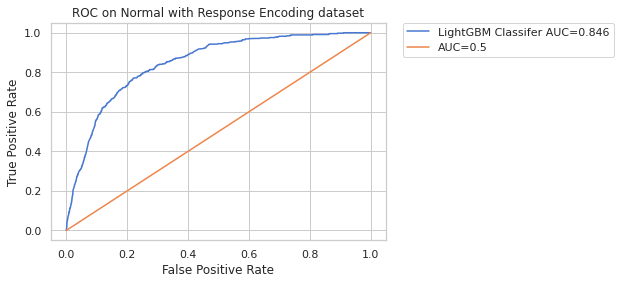

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[500,1000,2000],
          'max_depth':[500,1000,2000], 
         'min_samples_split':[100,500,1000],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250,500] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 41.2min finished


The best auc score was 0.821
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 7, 'max_leaf_nodes': 100, 'max_depth': 2000}
CPU times: user 1min 28s, sys: 271 ms, total: 1min 28s
Wall time: 42min 38s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=2000,
                                                             max_features='auto',
                                                             max_leaf_nodes=100,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=7,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (feature importance>0.01) on Normal with Response Encoding dataset 		 



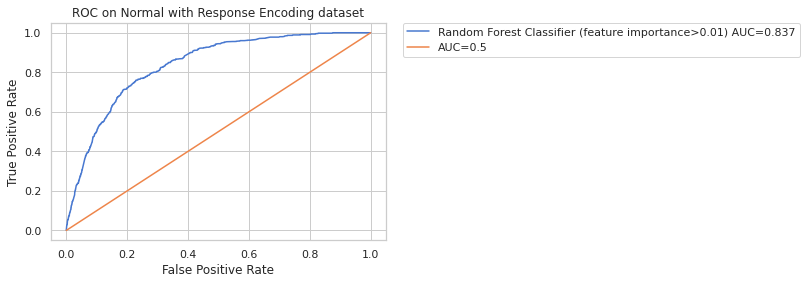

The log loss and auc was found to be 0.137 and 0.837 for Random Forest Classifier (feature importance>0.01) on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482
5,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136582,0.836654


# XGB Classifier (feature importance>0.01)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0.0,random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.81993	validation_0-error:0.039551
[1]	validation_0-auc:0.822987	validation_0-error:0.039551
[2]	validation_0-auc:0.824159	validation_0-error:0.039551
[3]	validation_0-auc:0.824262	validation_0-error:0.039551
[4]	validation_0-auc:0.825374	validation_0-error:0.039551
[5]	validation_0-auc:0.826279	validation_0-error:0.039551
[6]	validation_0-auc:0.82664	validation_0-error:0.039551
[7]	validation_0-auc:0.825253	validation_0-error:0.039551
[8]	validation_0-auc:0.824157	validation_0-error:0.039551
[9]	validation_0-auc:0.823941	validation_0-error:0.039551
[10]	validation_0-auc:0.823748	validation_0-error:0.039551
[11]	validation_0-auc:0.823611	validation_0-error:0.039551
[12]	validation_0-auc:0.824004	validation_0-error:0.039551
[13]	validation_0-auc:0.823843	validation_0-error:0.039551
[14]	validation_0-auc:0.823637	validation_0-error:0.039551
[15]	validation_0-auc:0.823931	validation_0-error:0.039551
[16]	validation_0-auc:0.82355	validation_0-error:0.039551
[17]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Normal with Response Encoding dataset 		 



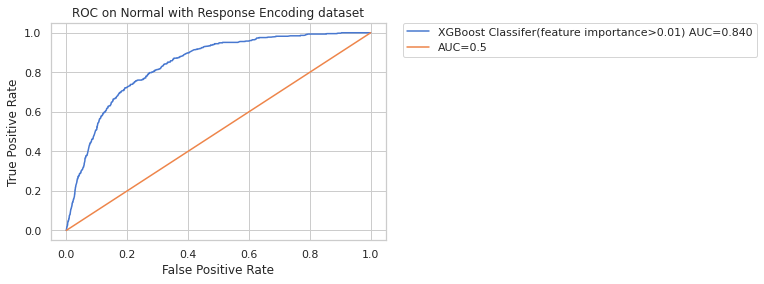

The log loss and auc was found to be 0.135 and 0.840 for XGBoost Classifer(feature importance>0.01) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482
5,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136582,0.836654
6,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.134969,0.839691


# LightGBM Classifier (feature importance>0.01)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=740,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=5,random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.814676	valid_0's binary_logloss: 0.165793
[2]	valid_0's auc: 0.824021	valid_0's binary_logloss: 0.165105
[3]	valid_0's auc: 0.824668	valid_0's binary_logloss: 0.164422
[4]	valid_0's auc: 0.826822	valid_0's binary_logloss: 0.163737
[5]	valid_0's auc: 0.829705	valid_0's binary_logloss: 0.163101
[6]	valid_0's auc: 0.83095	valid_0's binary_logloss: 0.162544
[7]	valid_0's auc: 0.831138	valid_0's binary_logloss: 0.161976
[8]	valid_0's auc: 0.830597	valid_0's binary_logloss: 0.161391
[9]	valid_0's auc: 0.830778	valid_0's binary_logloss: 0.160848
[10]	valid_0's auc: 0.830737	valid_0's binary_logloss: 0.160307
[11]	valid_0's auc: 0.830321	valid_0's binary_logloss: 0.159797
[12]	valid_0's auc: 0.830668	valid_0's binary_logloss: 0.159315
[13]	valid_0's auc: 0.83037	valid_0's binary_logloss: 0.158849
[14]	valid_0's auc: 0.830675	valid_0's binary_logloss: 0.15843
[15]	valid_0's auc: 0.830872	valid_0's binary_logloss: 0.157962
[16]	valid_0's auc: 0.831116	valid_0's binary_loglos

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=740, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Normal with Response Encoding dataset 		 



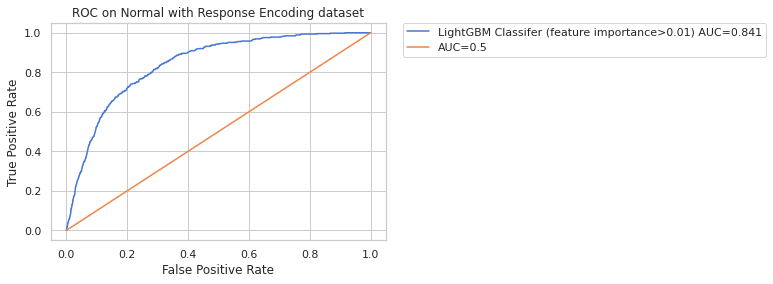

The log loss and auc was found to be 0.135 and 0.841 for LightGBM Classifer (feature importance>0.01) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482
5,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136582,0.836654
6,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.134969,0.839691
7,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134845,0.840624


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 40.4min finished


The best auc score was 0.824
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 4min 4s, sys: 534 ms, total: 4min 4s
Wall time: 44min 31s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (top 100) on Normal with Response Encoding dataset 		 



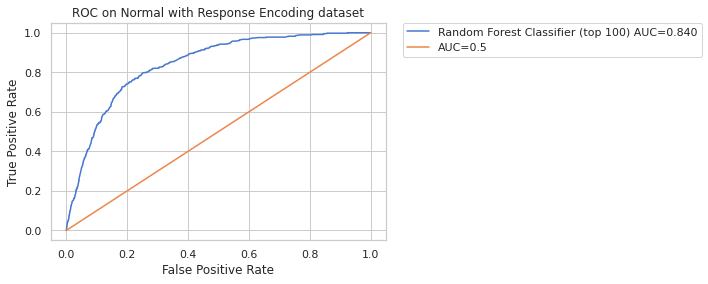

The log loss and auc was found to be 0.136 and 0.840 for Random Forest Classifier (top 100) on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482
5,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136582,0.836654
6,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.134969,0.839691
7,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134845,0.840624
8,Random Forest Classifier (top 100),Normal with Response Encoding,0.135572,0.840253


# XGB Classifier (top 100)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 1,
                      max_depth=7, 
                      gamma=0,random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.80223	validation_0-error:0.039551
[1]	validation_0-auc:0.81131	validation_0-error:0.039639
[2]	validation_0-auc:0.814167	validation_0-error:0.039551
[3]	validation_0-auc:0.817651	validation_0-error:0.039551
[4]	validation_0-auc:0.822001	validation_0-error:0.039551
[5]	validation_0-auc:0.82212	validation_0-error:0.039551
[6]	validation_0-auc:0.825578	validation_0-error:0.039551
[7]	validation_0-auc:0.826993	validation_0-error:0.039551
[8]	validation_0-auc:0.827985	validation_0-error:0.039551
[9]	validation_0-auc:0.827356	validation_0-error:0.039551
[10]	validation_0-auc:0.828021	validation_0-error:0.039551
[11]	validation_0-auc:0.827609	validation_0-error:0.039551
[12]	validation_0-auc:0.828057	validation_0-error:0.039551
[13]	validation_0-auc:0.829006	validation_0-error:0.039551
[14]	validation_0-auc:0.828526	validation_0-error:0.039551
[15]	validation_0-auc:0.82804	validation_0-error:0.039551
[16]	validation_0-auc:0.828498	validation_0-error:0.039551
[17]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Normal with Response Encoding dataset 		 



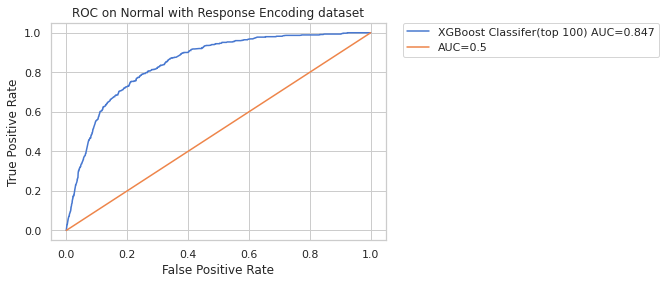

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 100) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482
5,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136582,0.836654
6,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.134969,0.839691
7,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134845,0.840624
8,Random Forest Classifier (top 100),Normal with Response Encoding,0.135572,0.840253
9,XGBoost Classifer(top 100),Normal with Response Encoding,0.132915,0.846882


# LightGBM Classifier (top 100)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=947,
                      reg_alpha = 0.4,
                      max_depth=6, 
                      gamma=0,random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.820021	valid_0's binary_logloss: 0.165766
[2]	valid_0's auc: 0.823738	valid_0's binary_logloss: 0.16514
[3]	valid_0's auc: 0.832459	valid_0's binary_logloss: 0.164425
[4]	valid_0's auc: 0.832224	valid_0's binary_logloss: 0.163816
[5]	valid_0's auc: 0.832748	valid_0's binary_logloss: 0.163177
[6]	valid_0's auc: 0.831503	valid_0's binary_logloss: 0.162666
[7]	valid_0's auc: 0.833112	valid_0's binary_logloss: 0.162076
[8]	valid_0's auc: 0.833771	valid_0's binary_logloss: 0.161539
[9]	valid_0's auc: 0.832921	valid_0's binary_logloss: 0.161065
[10]	valid_0's auc: 0.832745	valid_0's binary_logloss: 0.160538
[11]	valid_0's auc: 0.833067	valid_0's binary_logloss: 0.16004
[12]	valid_0's auc: 0.833896	valid_0's binary_logloss: 0.159523
[13]	valid_0's auc: 0.833301	valid_0's binary_logloss: 0.159068
[14]	valid_0's auc: 0.83372	valid_0's binary_logloss: 0.158575
[15]	valid_0's auc: 0.834364	valid_0's binary_logloss: 0.15812
[16]	valid_0's auc: 0.834457	valid_0's binary_logloss

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=947, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42,
               reg_alpha=0.4, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=1, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Normal with Response Encoding dataset 		 



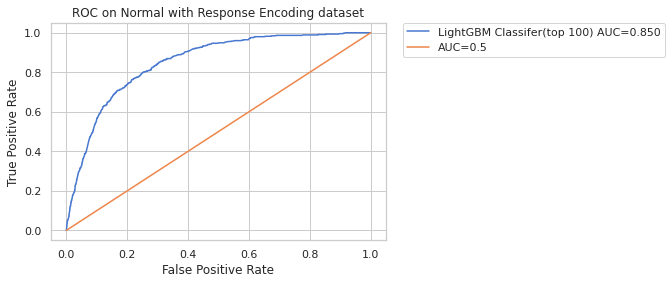

The log loss and auc was found to be 0.132 and 0.850 for LightGBM Classifer(top 100) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482
5,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136582,0.836654
6,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.134969,0.839691
7,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134845,0.840624
8,Random Forest Classifier (top 100),Normal with Response Encoding,0.135572,0.840253
9,XGBoost Classifer(top 100),Normal with Response Encoding,0.132915,0.846882


# Random Forest (top 250)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 58.7min finished


The best auc score was 0.822
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 4min 58s, sys: 640 ms, total: 4min 59s
Wall time: 1h 3min 42s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Normal with Response Encoding dataset 		 



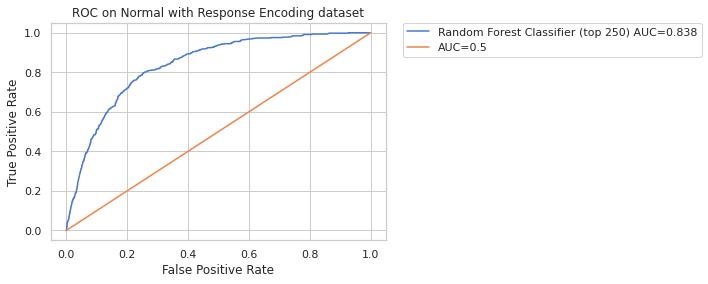

The log loss and auc was found to be 0.136 and 0.838 for Random Forest Classifier (top 250) on Normal with Response Encoding dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482
5,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136582,0.836654
6,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.134969,0.839691
7,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134845,0.840624
8,Random Forest Classifier (top 100),Normal with Response Encoding,0.135572,0.840253
9,XGBoost Classifer(top 100),Normal with Response Encoding,0.132915,0.846882


# XGB Classifier (top 250)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0,random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.802877	validation_0-error:0.039726
[1]	validation_0-auc:0.809588	validation_0-error:0.039639
[2]	validation_0-auc:0.815512	validation_0-error:0.039551
[3]	validation_0-auc:0.811591	validation_0-error:0.039551
[4]	validation_0-auc:0.815099	validation_0-error:0.039551
[5]	validation_0-auc:0.815334	validation_0-error:0.039551
[6]	validation_0-auc:0.816643	validation_0-error:0.039551
[7]	validation_0-auc:0.816478	validation_0-error:0.039551
[8]	validation_0-auc:0.817696	validation_0-error:0.039551
[9]	validation_0-auc:0.822784	validation_0-error:0.039551
[10]	validation_0-auc:0.825486	validation_0-error:0.039551
[11]	validation_0-auc:0.825487	validation_0-error:0.039551
[12]	validation_0-auc:0.825509	validation_0-error:0.039551
[13]	validation_0-auc:0.825309	validation_0-error:0.039551
[14]	validation_0-auc:0.825069	validation_0-error:0.039551
[15]	validation_0-auc:0.825346	validation_0-error:0.039551
[16]	validation_0-auc:0.825443	validation_0-error:0.039551
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Normal with Response Encoding dataset 		 



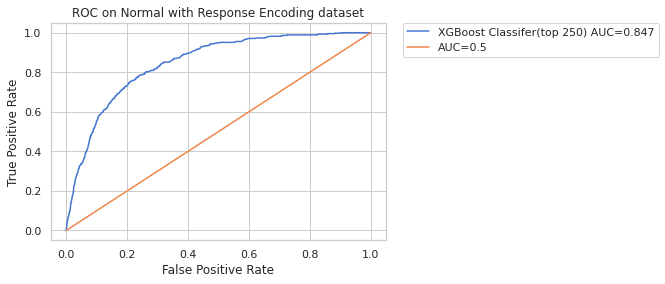

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 250) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with Response Encoding,0.523867,0.824059
1,Decision Tree Classifier,Normal with Response Encoding,0.148561,0.771846
2,Random Forest Classifier,Normal with Response Encoding,0.136781,0.836302
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482
5,Random Forest Classifier (feature importance>0...,Normal with Response Encoding,0.136582,0.836654
6,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.134969,0.839691
7,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134845,0.840624
8,Random Forest Classifier (top 100),Normal with Response Encoding,0.135572,0.840253
9,XGBoost Classifer(top 100),Normal with Response Encoding,0.132915,0.846882


# LightGBM Classifier (top 250)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=7,
                      gamma=5,random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's auc: 0.816541	valid_0's binary_logloss: 0.165727
[2]	valid_0's auc: 0.818231	valid_0's binary_logloss: 0.164993
[3]	valid_0's auc: 0.822648	valid_0's binary_logloss: 0.164404
[4]	valid_0's auc: 0.825316	valid_0's binary_logloss: 0.163716
[5]	valid_0's auc: 0.827709	valid_0's binary_logloss: 0.163102
[6]	valid_0's auc: 0.831687	valid_0's binary_logloss: 0.1625
[7]	valid_0's auc: 0.832289	valid_0's binary_logloss: 0.161866
[8]	valid_0's auc: 0.832016	valid_0's binary_logloss: 0.161374
[9]	valid_0's auc: 0.831523	valid_0's binary_logloss: 0.160891
[10]	valid_0's auc: 0.832896	valid_0's binary_logloss: 0.160337
[11]	valid_0's auc: 0.833727	valid_0's binary_logloss: 0.159796
[12]	valid_0's auc: 0.834119	valid_0's binary_logloss: 0.159252
[13]	valid_0's auc: 0.834121	valid_0's binary_logloss: 0.158819
[14]	valid_0's auc: 0.834325	valid_0's binary_logloss: 0.158348
[15]	valid_0's auc: 0.834988	valid_0's binary_logloss: 0.157893
[16]	valid_0's auc: 0.835327	valid_0's binary_loglo

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=447, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=42, reg_alpha=0,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=1,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Normal with Response Encoding dataset 		 



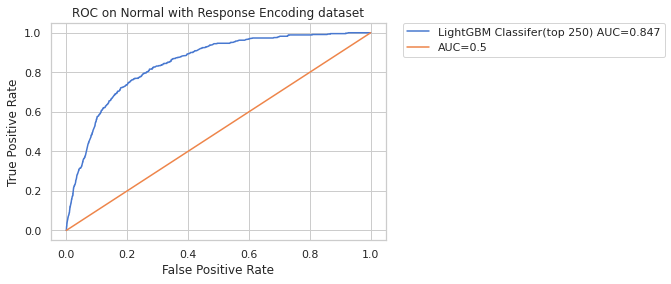

The log loss and auc was found to be 0.133 and 0.847 for LightGBM Classifer(top 250) on Normal with Response Encoding dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

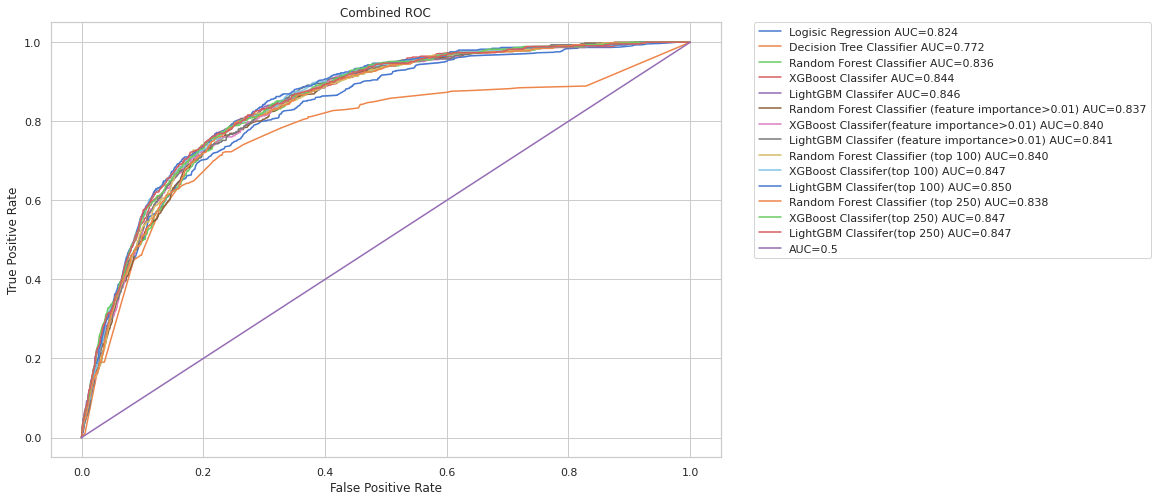

In [ ]:
plot_auc(y_val,y_preds,labels)

In [ ]:
result_df.sort_values(by='log_loss')

,Model,Dataset,log_loss,auc
10,LightGBM Classifer(top 100),Normal with Response Encoding,0.132046,0.850403
9,XGBoost Classifer(top 100),Normal with Response Encoding,0.132915,0.846882
12,XGBoost Classifer(top 250),Normal with Response Encoding,0.132950,0.846696
13,LightGBM Classifer(top 250),Normal with Response Encoding,0.132971,0.846689
4,LightGBM Classifer,Normal with Response Encoding,0.132995,0.846482
3,XGBoost Classifer,Normal with Response Encoding,0.133509,0.844006
7,LightGBM Classifer (feature importance>0.01),Normal with Response Encoding,0.134845,0.840624
6,XGBoost Classifer(feature importance>0.01),Normal with Response Encoding,0.134969,0.839691
8,Random Forest Classifier (top 100),Normal with Response Encoding,0.135572,0.840253
11,Random Forest Classifier (top 250),Normal with Response Encoding,0.136419,0.837542


# Saving all the datasets created

In [ ]:
import joblib
filename = 'normal_train_re_100.pkl'
X_train_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_val_re_100.pkl'
X_val_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_test_re_100.pkl'
X_test_100.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_train_re_250.pkl'
X_train_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_val_re_250.pkl'
X_val_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_test_re_250.pkl'
X_test_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_train_re_01.pkl'
X_train_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_val_re_01.pkl'
X_val_01.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'normal_test_re_01.pkl'
X_test_01.to_pickle(os.path.join(file_path,'best_models',filename))